# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

    Загрузите данные и выполните их ресемплирование по одному часу.
    Проанализируйте данные.
    Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
    Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле /datasets/taxi.csv.
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

### Libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 12, 8

### Загрузите данные и выполните их ресемплирование по одному часу.

In [2]:
taxi = pd.read_csv('taxi.csv')
taxi

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
taxi.duplicated().sum()

0

In [6]:
#### Количество дублей можно объяснить нулевыми значениями в заказах

In [7]:
### Изменим тип колонки datetime на datetime64

In [8]:
taxi['datetime'] = taxi['datetime'].astype('datetime64')

In [9]:
#### Сделаем колонку datetime индексом

In [10]:
taxi.set_index('datetime', inplace=True)

In [11]:
#### Отсортируем данные по индексу и проверим их на монотонность

In [12]:
taxi = taxi.sort_index()
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [13]:
taxi.index.is_monotonic

True

In [14]:
#### Проверим датасет на нулевые значения

In [15]:
taxi.isnull().sum()

num_orders    0
dtype: int64

In [16]:
#### Ресемплирование

In [17]:
taxi = taxi.resample('1H').sum()

In [18]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Проанализируйте данные.

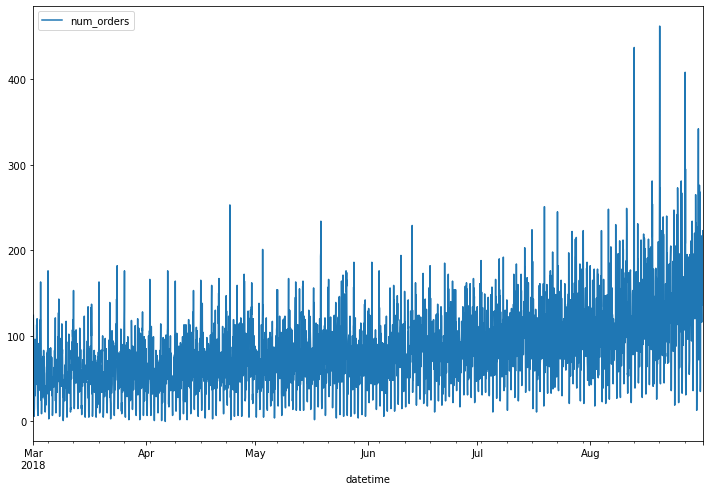

In [19]:
taxi.plot();

In [20]:
#### Разложим временной ряд на тренд и сезонную компоненту. 

In [21]:
decomposed = seasonal_decompose(taxi)

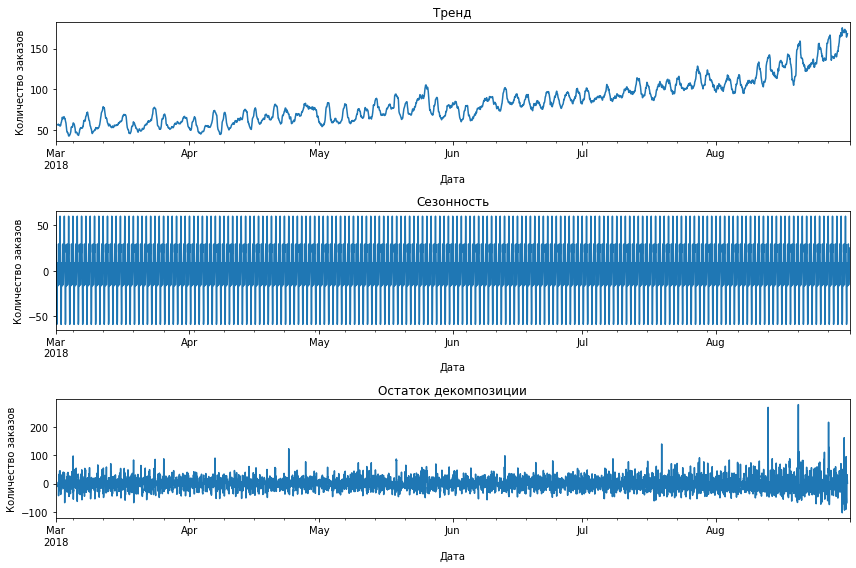

In [22]:
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остаток декомпозиции')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.tight_layout()

In [23]:
#### Для наглядности возмем меньший период времени - 1месяц

In [24]:
taxi.index.min(), taxi.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [25]:
decomposed = seasonal_decompose(taxi['2018-08':'2018-08'])

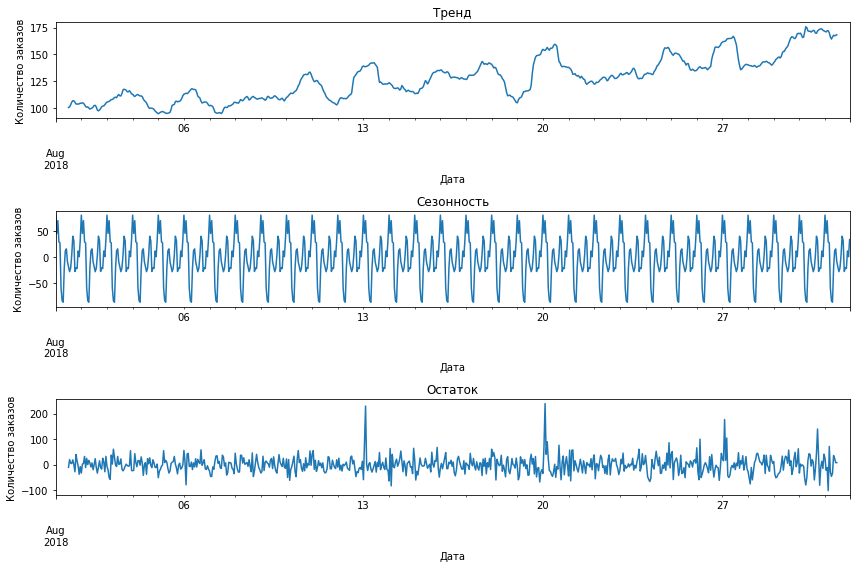

In [26]:
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остаток')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.tight_layout()

In [27]:
#### Посмотрим почасовое распределение по 1 дню

In [28]:
decomposed_1d = seasonal_decompose(taxi)

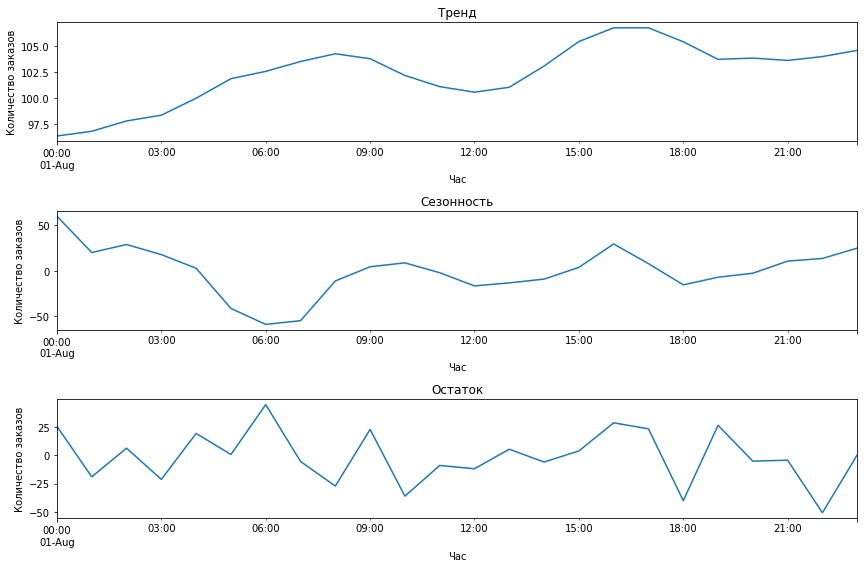

In [29]:
plt.subplot(311)
decomposed_1d.trend['2018-08-01':'2018-08-01'].plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Час')

plt.subplot(312)
decomposed_1d.seasonal['2018-08-01':'2018-08-01'].plot(ax=plt.gca())

plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Час')

plt.subplot(313)
decomposed_1d.resid['2018-08-01':'2018-08-01'].plot(ax=plt.gca())

plt.title('Остаток')
plt.ylabel('Количество заказов')
plt.xlabel('Час')
plt.tight_layout()

In [30]:
### Наблюдается падение количества заказов с 00 часов до 06 утра. Затем видно постепенный рост до 10-11 часов. Второй пик наблюдается в районе 15 часов и 21 часов.

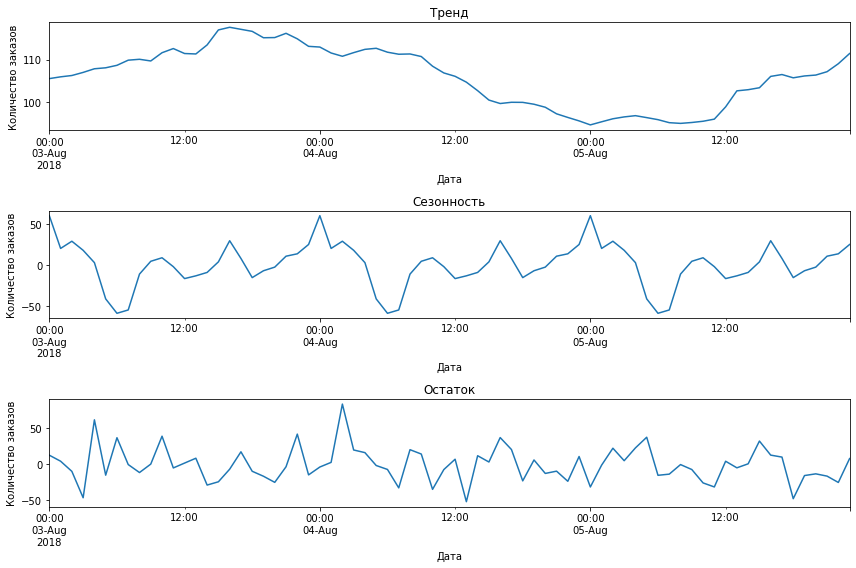

In [31]:
## Распределение в будни и выходные дни

plt.subplot(311)
decomposed_1d.trend['2018-08-03':'2018-08-05'].plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.subplot(312)
decomposed_1d.seasonal['2018-08-03':'2018-08-05'].plot(ax=plt.gca())

plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')

plt.subplot(313)
decomposed_1d.resid['2018-08-03':'2018-08-05'].plot(ax=plt.gca())

plt.title('Остаток')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.tight_layout()

### 
- На общем датасете видно восходящий тренд роста количества пользователейю Возможно связан с возвратом большого количества людей из отпусков и подготовкой детей к уебному году
- По графику сезонности наблюдается падение количества заказов с 00 часов до 06 утра. Затем видно постепенный рост до 10-11 часов. Второй пик наблюдается в районе 15 часов и 21 часов. Пики видимо связаны с деловой активность людей.
- В выходные дни высокая активность заказов такси наблюдается в ночное время. Вероятно люди возвращаются домой с места отдыха.

### Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

In [32]:
#### Сгенерируем новые признаки. Для этого напишем функцию

In [33]:
def make_feature(data, max_lag, rolling):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
#     data['is_weekend'] = data.dayofweek.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling).mean()
    
    return data

In [34]:
taxi_new = make_feature(taxi, 1, 24)

In [35]:
taxi_new

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,168.041667


In [36]:
### Разобъем датасет на выборки в пропорции 9:1

In [37]:
train, test = train_test_split(taxi_new, test_size=0.1, shuffle=False)

In [38]:
train.isnull().sum()

num_orders       0
dayofweek        0
hour             0
lag_1            1
rolling_mean    24
dtype: int64

In [39]:
train = train.dropna()

In [40]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3950, 4), (3950,), (442, 4), (442,))

In [42]:
#### Обучим модель линейной регрессии

In [43]:
linreg = LinearRegression()

In [44]:
linreg.fit(X_train, y_train)

LinearRegression()

In [45]:
def rmse(y_true, t_pred):
    return mean_squared_error(y_test, y_pred) ** 0.5

In [46]:
y_pred = linreg.predict(X_test)
print("RMSE на тестовой выборке: ", rmse(y_test, y_pred))

RMSE на тестовой выборке:  51.194080671652486


In [47]:
#### Минимального значения 48 не добились.

Попробуем  в цикле подобрать лучшие параметры (lag и rolling) для модели линейной регресcии

In [48]:
rolling_size = 0
lag = 0 
best_rmse_linreg = 48

for lag in range(1, 50, 5):
    for roll in range(1, 97, 23):
        
        taxi_= make_feature(taxi, lag, roll)
        
        train, test = train_test_split(taxi_, test_size=0.1, shuffle=False)
        train = train.dropna()
        
        X_train = train.drop('num_orders', axis=1)
        y_train = train['num_orders']
        X_test = test.drop('num_orders', axis=1)
        y_test = test['num_orders']
        
        linreg = LinearRegression()
        linreg.fit(X_train, y_train)
        
        y_pred = linreg.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred) ** 0.5
        
        if rmse < best_rmse_linreg:
            
            best_rmse_linreg = rmse
            lag = lag
            rolling_size = roll

In [49]:
print(f"RMSE на тестовой выборке: {best_rmse_linreg}, максимальное смещение {lag}, размер скользящего окна {rolling_size}")

RMSE на тестовой выборке: 43.49140278026316, максимальное смещение 46, размер скользящего окна 93


In [50]:
### Получили качество метрики RMSE лучше заданного уровня 48

In [51]:
#### Проведем расчет на других моделях

#### RandomForest -  подбор гиперпараметров

In [52]:
params_rf = {
            'n_estimators': [100], 
            'max_depth' : [5, 7, 9, 11],
            'random_state': [2021]}

In [53]:
clf_rf = RandomForestRegressor()

In [54]:
%%time

split_index_rf = TimeSeriesSplit().split(X_train)

rf_searcher = GridSearchCV(estimator=clf_rf, param_grid=params_rf, refit=False, 
                          scoring='neg_mean_squared_error', cv=split_index_rf)

rf_searcher.fit(X_train, y_train)

best_score_rf = rf_searcher.best_score_
best_params_rf = rf_searcher.best_params_

Wall time: 50.1 s


In [55]:
# y_pred_rf = gridsearch_rf.predict(X_test)

In [56]:
RMSE_rf = (-best_score_rf) ** 0.5

In [57]:
print('Лучшее значение метрики RMSE модели  RandomForestRegressor:', RMSE_rf)
print(f'Лучшие параметры:', best_params_rf)

Лучшее значение метрики RMSE модели  RandomForestRegressor: 25.61395025162707
Лучшие параметры: {'max_depth': 11, 'n_estimators': 100, 'random_state': 2021}


In [58]:
### RMSE лучше, чем у модели линейной регресии

#### LightGBM - подбор гиперпараметров

In [59]:
params_lgb = {'learning_rate': [0.01, 0.1, 0.15, 0.2],
              'n_estimators': [100], 
              'max_depth' : [5, 7, 9, 11], 
              'random_state': [2021]}

In [60]:
%%time

split_index = TimeSeriesSplit().split(X_train)

lgb_searcher = GridSearchCV(estimator=LGBMRegressor(random_state=2021), param_grid=params_lgb, refit=False, 
                          scoring='neg_mean_squared_error', cv=split_index)

lgb_searcher.fit(X_train, y_train)

best_score_lgb = lgb_searcher.best_score_
best_params_lgb = lgb_searcher.best_params_
# y_pred_lightgbm = gridsearch_cv.predict(X_test)

Wall time: 10.5 s


In [61]:
print('Лучшее значение метрики RMSE модели lightgbm:', (-best_score_lgb) ** 0.5)
print(f'Лучшие параметры:', best_params_lgb)

Лучшее значение метрики RMSE модели lightgbm: 25.11994394954698
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'random_state': 2021}


#### Catboost -  подбор гиперпараметров

In [62]:
params_сat = {'n_estimators': [100], 
              'max_depth' : [5, 7, 9, 11], 
              'random_state': [2021]}

In [63]:
catboost = CatBoostRegressor(random_state=2021)

In [64]:
%%time

split_index = TimeSeriesSplit().split(X_train)

cat_searcher = GridSearchCV(estimator=catboost, param_grid=params_сat, refit=False, 
                          scoring='neg_mean_squared_error', cv=split_index)

cat_searcher.fit(X_train, y_train)

best_score_cat = cat_searcher.best_score_
best_params_cat = cat_searcher.best_params_

Learning rate set to 0.208074
0:	learn: 26.6987973	total: 58.3ms	remaining: 5.78s
1:	learn: 24.6124332	total: 62.5ms	remaining: 3.06s
2:	learn: 23.1180415	total: 66ms	remaining: 2.13s
3:	learn: 21.8926922	total: 69.4ms	remaining: 1.67s
4:	learn: 20.9952643	total: 75.5ms	remaining: 1.43s
5:	learn: 20.2011251	total: 80ms	remaining: 1.25s
6:	learn: 19.5492280	total: 83.4ms	remaining: 1.11s
7:	learn: 19.0642602	total: 88.2ms	remaining: 1.01s
8:	learn: 18.6823148	total: 92.9ms	remaining: 939ms
9:	learn: 18.2860050	total: 96.4ms	remaining: 868ms
10:	learn: 17.8161581	total: 99.5ms	remaining: 805ms
11:	learn: 17.6065765	total: 104ms	remaining: 765ms
12:	learn: 17.3697434	total: 108ms	remaining: 721ms
13:	learn: 17.1408306	total: 110ms	remaining: 677ms
14:	learn: 16.8209327	total: 113ms	remaining: 638ms
15:	learn: 16.6085893	total: 115ms	remaining: 603ms
16:	learn: 16.4179576	total: 117ms	remaining: 572ms
17:	learn: 16.2731745	total: 122ms	remaining: 556ms
18:	learn: 16.0575743	total: 125ms	re

96:	learn: 10.2993197	total: 332ms	remaining: 10.3ms
97:	learn: 10.2350636	total: 335ms	remaining: 6.83ms
98:	learn: 10.2265707	total: 340ms	remaining: 3.43ms
99:	learn: 10.1384255	total: 343ms	remaining: 0us
Learning rate set to 0.252784
0:	learn: 29.2416307	total: 3.66ms	remaining: 363ms
1:	learn: 27.2640515	total: 8.71ms	remaining: 427ms
2:	learn: 25.4407000	total: 12.4ms	remaining: 401ms
3:	learn: 23.8837310	total: 15.6ms	remaining: 375ms
4:	learn: 22.8602970	total: 18.7ms	remaining: 355ms
5:	learn: 22.0577576	total: 21.7ms	remaining: 340ms
6:	learn: 21.4409793	total: 27.3ms	remaining: 363ms
7:	learn: 20.9803652	total: 30.7ms	remaining: 353ms
8:	learn: 20.5519950	total: 33.9ms	remaining: 342ms
9:	learn: 20.2002175	total: 37ms	remaining: 333ms
10:	learn: 19.8378155	total: 42.3ms	remaining: 342ms
11:	learn: 19.6687208	total: 45.7ms	remaining: 335ms
12:	learn: 19.4035197	total: 48.8ms	remaining: 327ms
13:	learn: 19.2312024	total: 51.9ms	remaining: 319ms
14:	learn: 19.0091310	total: 57

80:	learn: 14.0882937	total: 341ms	remaining: 79.9ms
81:	learn: 14.0095302	total: 344ms	remaining: 75.6ms
82:	learn: 13.9251260	total: 348ms	remaining: 71.2ms
83:	learn: 13.9184683	total: 353ms	remaining: 67.2ms
84:	learn: 13.8525862	total: 356ms	remaining: 62.9ms
85:	learn: 13.7864590	total: 360ms	remaining: 58.5ms
86:	learn: 13.7123830	total: 364ms	remaining: 54.4ms
87:	learn: 13.6488460	total: 370ms	remaining: 50.5ms
88:	learn: 13.5712176	total: 374ms	remaining: 46.2ms
89:	learn: 13.5475266	total: 377ms	remaining: 41.9ms
90:	learn: 13.5316616	total: 384ms	remaining: 37.9ms
91:	learn: 13.4760235	total: 387ms	remaining: 33.7ms
92:	learn: 13.4084389	total: 391ms	remaining: 29.4ms
93:	learn: 13.3512991	total: 397ms	remaining: 25.3ms
94:	learn: 13.2989215	total: 401ms	remaining: 21.1ms
95:	learn: 13.2254732	total: 404ms	remaining: 16.8ms
96:	learn: 13.1554129	total: 408ms	remaining: 12.6ms
97:	learn: 13.1059638	total: 414ms	remaining: 8.44ms
98:	learn: 13.0647983	total: 417ms	remaining: 

38:	learn: 10.2059918	total: 367ms	remaining: 574ms
39:	learn: 10.0250839	total: 376ms	remaining: 564ms
40:	learn: 9.8575176	total: 390ms	remaining: 561ms
41:	learn: 9.7340246	total: 402ms	remaining: 555ms
42:	learn: 9.5079086	total: 410ms	remaining: 543ms
43:	learn: 9.2190253	total: 420ms	remaining: 534ms
44:	learn: 9.0388502	total: 432ms	remaining: 528ms
45:	learn: 8.8809848	total: 446ms	remaining: 523ms
46:	learn: 8.7146460	total: 454ms	remaining: 512ms
47:	learn: 8.5512477	total: 462ms	remaining: 501ms
48:	learn: 8.4158445	total: 470ms	remaining: 489ms
49:	learn: 8.3847634	total: 478ms	remaining: 478ms
50:	learn: 8.2000601	total: 486ms	remaining: 467ms
51:	learn: 8.1512712	total: 494ms	remaining: 456ms
52:	learn: 8.1138793	total: 503ms	remaining: 446ms
53:	learn: 7.9839954	total: 512ms	remaining: 436ms
54:	learn: 7.8539639	total: 519ms	remaining: 425ms
55:	learn: 7.6756627	total: 528ms	remaining: 415ms
56:	learn: 7.6423193	total: 535ms	remaining: 404ms
57:	learn: 7.5391944	total: 5

Learning rate set to 0.252784
0:	learn: 29.0486557	total: 38.5ms	remaining: 3.81s
1:	learn: 26.3952210	total: 56.4ms	remaining: 2.76s
2:	learn: 24.4007881	total: 67.8ms	remaining: 2.19s
3:	learn: 22.7995671	total: 79ms	remaining: 1.9s
4:	learn: 21.6217729	total: 90ms	remaining: 1.71s
5:	learn: 21.0105548	total: 99.7ms	remaining: 1.56s
6:	learn: 20.1251420	total: 116ms	remaining: 1.55s
7:	learn: 19.6017302	total: 131ms	remaining: 1.5s
8:	learn: 19.1869830	total: 142ms	remaining: 1.43s
9:	learn: 18.8181268	total: 153ms	remaining: 1.38s
10:	learn: 18.4185185	total: 167ms	remaining: 1.35s
11:	learn: 18.0098449	total: 181ms	remaining: 1.33s
12:	learn: 17.7219922	total: 192ms	remaining: 1.28s
13:	learn: 17.4708340	total: 204ms	remaining: 1.25s
14:	learn: 17.2384612	total: 215ms	remaining: 1.22s
15:	learn: 17.0867585	total: 225ms	remaining: 1.18s
16:	learn: 16.6916129	total: 236ms	remaining: 1.15s
17:	learn: 16.4685075	total: 247ms	remaining: 1.13s
18:	learn: 16.2899080	total: 257ms	remaining

64:	learn: 12.2790791	total: 745ms	remaining: 401ms
65:	learn: 12.1424135	total: 755ms	remaining: 389ms
66:	learn: 12.0370430	total: 766ms	remaining: 377ms
67:	learn: 11.9074263	total: 777ms	remaining: 366ms
68:	learn: 11.8434596	total: 788ms	remaining: 354ms
69:	learn: 11.6963880	total: 798ms	remaining: 342ms
70:	learn: 11.6039590	total: 810ms	remaining: 331ms
71:	learn: 11.5715647	total: 820ms	remaining: 319ms
72:	learn: 11.4095293	total: 830ms	remaining: 307ms
73:	learn: 11.3416990	total: 841ms	remaining: 296ms
74:	learn: 11.1978308	total: 852ms	remaining: 284ms
75:	learn: 11.1101726	total: 862ms	remaining: 272ms
76:	learn: 11.0993151	total: 873ms	remaining: 261ms
77:	learn: 11.0466119	total: 885ms	remaining: 250ms
78:	learn: 11.0382742	total: 895ms	remaining: 238ms
79:	learn: 10.9670807	total: 907ms	remaining: 227ms
80:	learn: 10.8481004	total: 919ms	remaining: 216ms
81:	learn: 10.7545793	total: 929ms	remaining: 204ms
82:	learn: 10.6851666	total: 941ms	remaining: 193ms
83:	learn: 1

23:	learn: 10.4540597	total: 774ms	remaining: 2.45s
24:	learn: 10.1482463	total: 803ms	remaining: 2.41s
25:	learn: 9.9617189	total: 834ms	remaining: 2.37s
26:	learn: 9.7551900	total: 864ms	remaining: 2.33s
27:	learn: 9.6373770	total: 894ms	remaining: 2.3s
28:	learn: 9.3638436	total: 925ms	remaining: 2.26s
29:	learn: 9.1220341	total: 956ms	remaining: 2.23s
30:	learn: 8.9036488	total: 986ms	remaining: 2.19s
31:	learn: 8.6065750	total: 1.01s	remaining: 2.16s
32:	learn: 8.3214981	total: 1.05s	remaining: 2.12s
33:	learn: 8.1783855	total: 1.08s	remaining: 2.09s
34:	learn: 7.9737097	total: 1.1s	remaining: 2.05s
35:	learn: 7.8026059	total: 1.14s	remaining: 2.02s
36:	learn: 7.5740323	total: 1.17s	remaining: 1.98s
37:	learn: 7.3114929	total: 1.2s	remaining: 1.95s
38:	learn: 7.1047395	total: 1.23s	remaining: 1.92s
39:	learn: 6.9784824	total: 1.26s	remaining: 1.89s
40:	learn: 6.8599952	total: 1.29s	remaining: 1.86s
41:	learn: 6.6329632	total: 1.32s	remaining: 1.83s
42:	learn: 6.5932974	total: 1.35

85:	learn: 4.7758424	total: 2.99s	remaining: 488ms
86:	learn: 4.7059073	total: 3.03s	remaining: 453ms
87:	learn: 4.5867008	total: 3.06s	remaining: 418ms
88:	learn: 4.4958828	total: 3.1s	remaining: 383ms
89:	learn: 4.4884171	total: 3.13s	remaining: 348ms
90:	learn: 4.4257448	total: 3.17s	remaining: 313ms
91:	learn: 4.4183314	total: 3.2s	remaining: 279ms
92:	learn: 4.3076371	total: 3.24s	remaining: 244ms
93:	learn: 4.2174181	total: 3.27s	remaining: 209ms
94:	learn: 4.1080966	total: 3.31s	remaining: 174ms
95:	learn: 4.0391824	total: 3.34s	remaining: 139ms
96:	learn: 3.9625036	total: 3.38s	remaining: 104ms
97:	learn: 3.8949500	total: 3.41s	remaining: 69.6ms
98:	learn: 3.8323843	total: 3.45s	remaining: 34.8ms
99:	learn: 3.7661635	total: 3.48s	remaining: 0us
Learning rate set to 0.252784
0:	learn: 28.9939106	total: 48.9ms	remaining: 4.84s
1:	learn: 26.2562760	total: 88.2ms	remaining: 4.32s
2:	learn: 24.3209403	total: 129ms	remaining: 4.17s
3:	learn: 22.8688431	total: 170ms	remaining: 4.09s
4

46:	learn: 11.2188485	total: 2.54s	remaining: 2.87s
47:	learn: 11.0312488	total: 2.59s	remaining: 2.8s
48:	learn: 10.8754528	total: 2.63s	remaining: 2.73s
49:	learn: 10.7652613	total: 2.67s	remaining: 2.67s
50:	learn: 10.6577696	total: 2.71s	remaining: 2.6s
51:	learn: 10.4399726	total: 2.75s	remaining: 2.54s
52:	learn: 10.2858493	total: 2.79s	remaining: 2.48s
53:	learn: 10.1076803	total: 2.84s	remaining: 2.42s
54:	learn: 9.9758086	total: 2.88s	remaining: 2.36s
55:	learn: 9.7635667	total: 2.92s	remaining: 2.3s
56:	learn: 9.6464654	total: 2.96s	remaining: 2.24s
57:	learn: 9.6376551	total: 3.01s	remaining: 2.18s
58:	learn: 9.4331421	total: 3.06s	remaining: 2.13s
59:	learn: 9.2604684	total: 3.11s	remaining: 2.08s
60:	learn: 9.2512000	total: 3.16s	remaining: 2.02s
61:	learn: 9.1112030	total: 3.22s	remaining: 1.97s
62:	learn: 9.0072670	total: 3.27s	remaining: 1.92s
63:	learn: 8.8662340	total: 3.31s	remaining: 1.86s
64:	learn: 8.7687637	total: 3.35s	remaining: 1.81s
65:	learn: 8.7509496	total

5:	learn: 19.5011480	total: 1.37s	remaining: 21.4s
6:	learn: 18.3467153	total: 1.62s	remaining: 21.5s
7:	learn: 17.3566322	total: 1.85s	remaining: 21.3s
8:	learn: 16.4547521	total: 2.1s	remaining: 21.2s
9:	learn: 15.5963863	total: 2.49s	remaining: 22.4s
10:	learn: 14.8630983	total: 2.82s	remaining: 22.8s
11:	learn: 14.1442231	total: 3.26s	remaining: 23.9s
12:	learn: 13.6039744	total: 3.67s	remaining: 24.6s
13:	learn: 13.0806594	total: 4.02s	remaining: 24.7s
14:	learn: 12.5268648	total: 4.39s	remaining: 24.9s
15:	learn: 12.1067631	total: 4.73s	remaining: 24.8s
16:	learn: 11.6983912	total: 5.04s	remaining: 24.6s
17:	learn: 11.2910769	total: 5.33s	remaining: 24.3s
18:	learn: 10.9091653	total: 5.65s	remaining: 24.1s
19:	learn: 10.6521741	total: 5.96s	remaining: 23.9s
20:	learn: 10.2362095	total: 6.24s	remaining: 23.5s
21:	learn: 9.8556647	total: 6.5s	remaining: 23s
22:	learn: 9.5498432	total: 6.71s	remaining: 22.5s
23:	learn: 9.2242828	total: 6.96s	remaining: 22s
24:	learn: 9.0139553	total

66:	learn: 2.8691544	total: 18.2s	remaining: 8.94s
67:	learn: 2.7854329	total: 18.4s	remaining: 8.66s
68:	learn: 2.6845518	total: 18.7s	remaining: 8.38s
69:	learn: 2.5724793	total: 18.9s	remaining: 8.1s
70:	learn: 2.4952390	total: 19.2s	remaining: 7.83s
71:	learn: 2.4501681	total: 19.4s	remaining: 7.55s
72:	learn: 2.4298908	total: 19.7s	remaining: 7.28s
73:	learn: 2.4137439	total: 19.9s	remaining: 7s
74:	learn: 2.3806453	total: 20.2s	remaining: 6.74s
75:	learn: 2.3756649	total: 20.5s	remaining: 6.46s
76:	learn: 2.3141671	total: 20.7s	remaining: 6.19s
77:	learn: 2.2428746	total: 21.1s	remaining: 5.94s
78:	learn: 2.1820182	total: 21.4s	remaining: 5.69s
79:	learn: 2.1133428	total: 21.7s	remaining: 5.42s
80:	learn: 2.0646782	total: 21.9s	remaining: 5.15s
81:	learn: 2.0167295	total: 22.3s	remaining: 4.89s
82:	learn: 1.9899266	total: 22.5s	remaining: 4.61s
83:	learn: 1.9866051	total: 22.8s	remaining: 4.33s
84:	learn: 1.9125617	total: 23s	remaining: 4.06s
85:	learn: 1.8480686	total: 23.3s	rem

26:	learn: 11.3750275	total: 8.54s	remaining: 23.1s
27:	learn: 11.1166231	total: 8.86s	remaining: 22.8s
28:	learn: 10.8828316	total: 9.16s	remaining: 22.4s
29:	learn: 10.6676744	total: 9.51s	remaining: 22.2s
30:	learn: 10.5130311	total: 9.85s	remaining: 21.9s
31:	learn: 10.4164930	total: 10.2s	remaining: 21.7s
32:	learn: 10.2292609	total: 10.5s	remaining: 21.3s
33:	learn: 10.0121205	total: 10.9s	remaining: 21.1s
34:	learn: 9.7659346	total: 11.2s	remaining: 20.8s
35:	learn: 9.5218039	total: 11.5s	remaining: 20.5s
36:	learn: 9.2998197	total: 11.9s	remaining: 20.2s
37:	learn: 9.1189953	total: 12.2s	remaining: 20s
38:	learn: 9.1079763	total: 12.6s	remaining: 19.7s
39:	learn: 8.8644631	total: 12.9s	remaining: 19.4s
40:	learn: 8.8470090	total: 13s	remaining: 18.7s
41:	learn: 8.5984672	total: 13.3s	remaining: 18.4s
42:	learn: 8.4024612	total: 13.7s	remaining: 18.1s
43:	learn: 8.1978301	total: 14s	remaining: 17.8s
44:	learn: 7.9978941	total: 14.4s	remaining: 17.5s
45:	learn: 7.7394459	total: 1

87:	learn: 4.3626434	total: 30.2s	remaining: 4.11s
88:	learn: 4.2931951	total: 30.5s	remaining: 3.77s
89:	learn: 4.2482968	total: 30.9s	remaining: 3.43s
90:	learn: 4.1605338	total: 31.2s	remaining: 3.08s
91:	learn: 4.1572045	total: 31.5s	remaining: 2.74s
92:	learn: 4.1026301	total: 31.9s	remaining: 2.4s
93:	learn: 3.9536388	total: 32.2s	remaining: 2.06s
94:	learn: 3.9229754	total: 32.6s	remaining: 1.72s
95:	learn: 3.8510350	total: 32.9s	remaining: 1.37s
96:	learn: 3.7288504	total: 33.3s	remaining: 1.03s
97:	learn: 3.6916589	total: 33.7s	remaining: 687ms
98:	learn: 3.6067578	total: 34s	remaining: 343ms
99:	learn: 3.5378093	total: 34.3s	remaining: 0us
Wall time: 3min 8s


In [65]:
print('Лучшее значение метрики RMSE модели catboost:', (-best_score_cat) ** 0.5)
print(f'Лучшие параметры:', best_params_cat)

Лучшее значение метрики RMSE модели catboost: 25.273674409472257
Лучшие параметры: {'max_depth': 7, 'n_estimators': 100, 'random_state': 2021}


### Проверьте данные на тестовой выборке и сделайте выводы.

#### Проверим данные на разных моделях с лучшими гиперпараметрами

#### 1. RandomForest

In [66]:
clf_rf = RandomForestRegressor(max_depth=11, 
                               n_estimators=100, 
                               random_state=2021)

In [67]:
clf_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, random_state=2021)

In [68]:
y_pred_rf = clf_rf.predict(X_test)

In [69]:
RMSE_random_forest = mean_squared_error(y_test, y_pred_rf) **0.5

In [70]:
print(f"RMSE на тестовой выборке: {RMSE_random_forest}")

RMSE на тестовой выборке: 42.82114693803403


#### 2. LightGBM

In [71]:
clf_lgb = LGBMRegressor(n_estimators=100, 
                        learning_rate=0.1,
                        max_depth=9, 
                        random_state=2021)

In [72]:
clf_lgb.fit(X_train, y_train)

LGBMRegressor(max_depth=9, random_state=2021)

In [73]:
y_pred_lgb = clf_lgb.predict(X_test)

In [74]:
RMSE_lgb = mean_squared_error(y_test, y_pred_lgb) ** 0.5

In [75]:
print(f"RMSE на тестовой выборке: {RMSE_lgb}")

RMSE на тестовой выборке: 43.2724499249164


#### 3. Catboost

In [76]:
clf_cat = CatBoostRegressor(max_depth=7,                      
                            n_estimators=100, 
                            random_state=2021)

In [77]:
clf_cat.fit(X_train, y_train)

Learning rate set to 0.285912
0:	learn: 33.6672920	total: 24.1ms	remaining: 2.38s
1:	learn: 30.1237958	total: 41.9ms	remaining: 2.05s
2:	learn: 27.8743046	total: 58.2ms	remaining: 1.88s
3:	learn: 26.3710415	total: 71.9ms	remaining: 1.73s
4:	learn: 25.3149974	total: 85.4ms	remaining: 1.62s
5:	learn: 24.6599683	total: 98.5ms	remaining: 1.54s
6:	learn: 23.9933669	total: 113ms	remaining: 1.5s
7:	learn: 23.8403202	total: 127ms	remaining: 1.46s
8:	learn: 23.6220555	total: 140ms	remaining: 1.41s
9:	learn: 23.0742872	total: 153ms	remaining: 1.38s
10:	learn: 22.6800390	total: 167ms	remaining: 1.35s
11:	learn: 22.2981150	total: 180ms	remaining: 1.32s
12:	learn: 21.9462758	total: 195ms	remaining: 1.3s
13:	learn: 21.7475986	total: 209ms	remaining: 1.28s
14:	learn: 21.6099096	total: 223ms	remaining: 1.26s
15:	learn: 21.4787981	total: 236ms	remaining: 1.24s
16:	learn: 21.3432476	total: 249ms	remaining: 1.22s
17:	learn: 21.2135125	total: 262ms	remaining: 1.2s
18:	learn: 21.0387151	total: 276ms	remain

In [78]:
y_pred_cat = clf_cat.predict(X_test)

In [79]:
RMSE_cat = mean_squared_error(y_test, y_pred_cat) ** 0.5

In [80]:
print(f"RMSE на тестовой выборке: {RMSE_cat}")

RMSE на тестовой выборке: 43.00865673249074


In [81]:
#### Сводная таблица для оценки метрики RMSE

In [82]:
data_report = {'model' : ['LinearRegression', 'RandomForestRegressor', 'LightGBM', 
                'Catboost'],
    'RMSE' : pd.Series([best_rmse_linreg, RMSE_random_forest, RMSE_lgb, RMSE_cat])}
                      

In [84]:
data_report = pd.DataFrame(data_report)
data_report

,model,RMSE
0,LinearRegression,43.491403
1,RandomForestRegressor,42.821147
2,LightGBM,43.272450
3,Catboost,43.008657


In [ ]:
#### Модели имеют близкие по значение метрики RMSE, но лучшая модель  - RandomForest. Нужно учитывать, что поиск гиперпараметров произвол=дился практически по одним наборам значений, что не очень правильно для разных модели, но задачи такой в данном задании не стояло

In [90]:
clf_rf = RandomForestRegressor(max_depth=11, 
                               n_estimators=100, 
                               random_state=2021)

In [91]:
clf_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, random_state=2021)

In [92]:
y_pred_rf = pd.Series(clf_rf.predict(X_test), index = y_test.index, name='predictions')

In [93]:
data_predictions = pd.concat([y_test, y_pred_rf], axis=1)
data_predictions.head()

,num_orders,predictions
datetime,,
2018-08-13 14:00:00,102,115.787433
2018-08-13 15:00:00,175,134.991234
2018-08-13 16:00:00,144,152.893160
2018-08-13 17:00:00,152,124.732161
2018-08-13 18:00:00,104,104.470214


In [94]:
#### Построим график сравнения истинных значений и предсказанным с помощью модели RandomForest

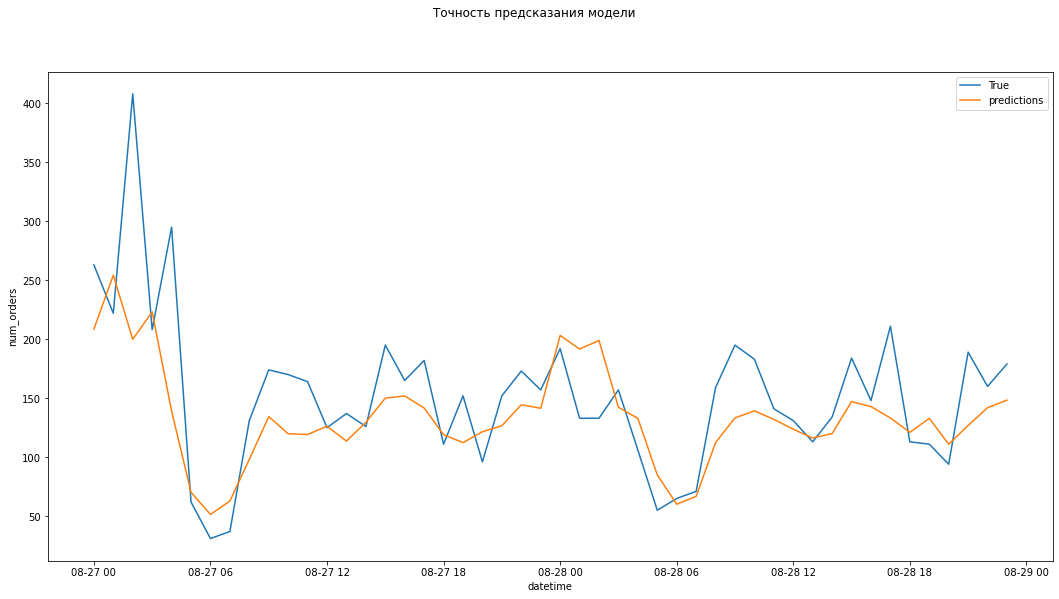

In [95]:
plt.figure(figsize=(18, 9))

#Возьмем небольшой период для анализа 
data = data_predictions['2018-08-27':'2018-08-28']

sns.lineplot(x=data.index, y=data['num_orders'], label='True')
sns.lineplot(x=data.index, y=data['predictions'], label='predictions')
plt.suptitle('Точность предсказания модели')
plt.show()

In [ ]:
#### По графику видны расхождения. Модель можно и нужно улучшать. 